# Cryptographic Analysis using CPA

In this assignment, we will analyze pre-recorded power traces to extract secret cryptographic key using Correlation Power Analysis (CPA).

The power traces were collected from an FPGA which implemented the cryptographic function:
$$
f(p,k) = \text{SBOX}(p\oplus k), p,k\in \mathbb{Z}_{16}
$$

The output of this function is sampled using Flip-Flops.

### Reading the data, and importing the SBOX

In [190]:
import mat73

# Load the plaintext adn power traces
PLAINTEXT = mat73.loadmat('inputs.mat')['plain']
POWER_TRACES = mat73.loadmat('cmos_exper.mat')['Imat']

# We translated the SBOX to python instead of dealing with matlab engine - seemed easier
SBOX4 = [12, 5, 6, 11, 9, 0, 10, 13, 3, 14, 15, 8, 4, 7 ,1 , 2]

In [191]:
SYMBOL_WIDTH = 4
POSSIBLE_KEYS = [*range(2 ** SYMBOL_WIDTH)]

def hamming_weight(value: int) -> int:
    assert 0 <= value < 2 ** SYMBOL_WIDTH, f"{value} is not a symbol in our problem"
    return sum([((value & (1 << i)) != 0) for i in range(SYMBOL_WIDTH)])

def hamming_distance(a: int, b: int) -> int:
    return hamming_weight(a ^ b)


[[7, 4, 2, 1, 14, 3, 8, 15, 0, 9, 13, 10, 5, 12, 11, 6], [13, 10, 0, 9, 11, 6, 5, 12, 2, 1, 7, 4, 8, 15, 14, 3], [5, 12, 11, 6, 0, 9, 13, 10, 14, 3, 8, 15, 7, 4, 2, 1], [1, 2, 4, 7, 15, 8, 3, 14, 10, 13, 9, 0, 6, 11, 12, 5], [12, 5, 6, 11, 9, 0, 10, 13, 3, 14, 15, 8, 4, 7, 1, 2], [3, 14, 15, 8, 4, 7, 1, 2, 12, 5, 6, 11, 9, 0, 10, 13], [15, 8, 3, 14, 1, 2, 4, 7, 6, 11, 12, 5, 10, 13, 9, 0], [0, 9, 13, 10, 5, 12, 11, 6, 7, 4, 2, 1, 14, 3, 8, 15], [1, 2, 4, 7, 15, 8, 3, 14, 10, 13, 9, 0, 6, 11, 12, 5], [5, 12, 11, 6, 0, 9, 13, 10, 14, 3, 8, 15, 7, 4, 2, 1], [6, 11, 12, 5, 10, 13, 9, 0, 15, 8, 3, 14, 1, 2, 4, 7], [2, 1, 7, 4, 8, 15, 14, 3, 13, 10, 0, 9, 11, 6, 5, 12], [9, 0, 10, 13, 12, 5, 6, 11, 4, 7, 1, 2, 3, 14, 15, 8], [9, 0, 10, 13, 12, 5, 6, 11, 4, 7, 1, 2, 3, 14, 15, 8], [11, 6, 5, 12, 13, 10, 0, 9, 8, 15, 14, 3, 2, 1, 7, 4], [10, 13, 9, 0, 6, 11, 12, 5, 1, 2, 4, 7, 15, 8, 3, 14], [4, 7, 1, 2, 3, 14, 15, 8, 9, 0, 10, 13, 12, 5, 6, 11], [1, 2, 4, 7, 15, 8, 3, 14, 10, 13, 9, 0, 6, 11,

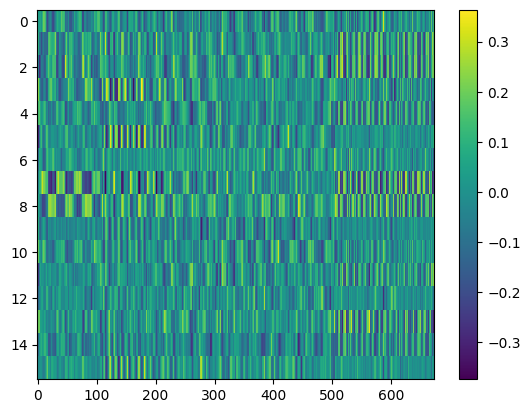

In [192]:
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt


def calc_poi_values(plaintext: list) -> list[list[int]]:
    res = []
    for item in plaintext:
        res.append([SBOX4[int(item) ^ key] for key in POSSIBLE_KEYS])
    return res


def calc_poi_power_hw(poi_values: list[list[int]]) -> list[list[int]]:
    res = []
    for row in poi_values:
        res.append([hamming_weight(item) for item in row])
    return res


def calc_poi_power_hd(poi_values: list[list[int]]) -> list[list[int]]:
    res = []
    last_row = [0] * len(poi_values[0])
    for row in poi_values:
        res.append([hamming_distance(item, last_row[i]) for i, item in enumerate(row)])
        last_row = row
    return res


print(values := calc_poi_values(PLAINTEXT))
print(calc_poi_power_hw(values))


def calculate_correlation_matrix(h, t):
    """
    Calculate the correlation coefficient matrix between two matrices h and t.

    Args:
        h: Hypothetical matrix (D x Ih)
        t: Measured matrix (D x It)

    Returns:
        Correlation coefficient matrix (Ih x It)
    """
    # Center the matrices by subtracting their means
    h_centered = h - np.mean(h, axis=0, keepdims=True)
    t_centered = t - np.mean(t, axis=0, keepdims=True)

    # Calculate covariance
    cov = h_centered.T @ t_centered

    # Calculate standard deviations
    sigma_h = np.sqrt(np.sum(h_centered**2, axis=0))
    sigma_t = np.sqrt(np.sum(t_centered**2, axis=0))

    # Calculate correlation coefficients
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    corr_matrix = cov / (np.outer(sigma_h, sigma_t) + epsilon)

    return corr_matrix


mat_hw = (
    calculate_correlation_matrix(
        calc_poi_power_hw(calc_poi_values(PLAINTEXT)), POWER_TRACES
    ),
)[0]

mat_hd = (
    calculate_correlation_matrix(
        calc_poi_power_hd(calc_poi_values(PLAINTEXT)), POWER_TRACES
    ),
)[0]

mat_val = (calculate_correlation_matrix(calc_poi_values(PLAINTEXT), POWER_TRACES))


plt.imshow(mat_hw, interpolation="nearest", aspect="auto")
plt.colorbar()

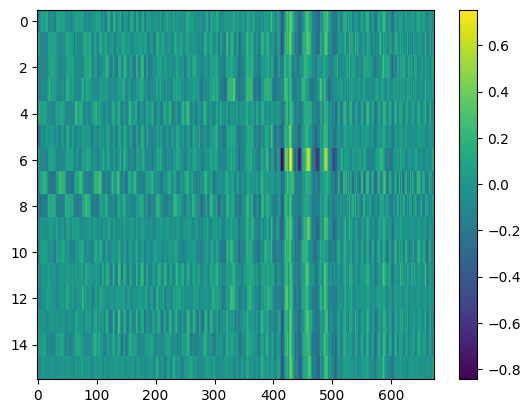

In [193]:
plt.imshow(mat_hd, interpolation="nearest", aspect="auto")
plt.colorbar()

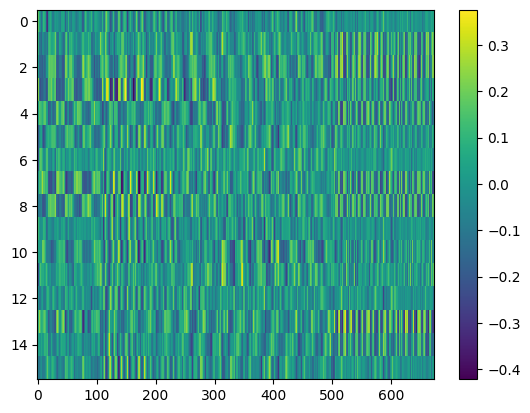

In [194]:
plt.imshow(mat_val, interpolation="nearest", aspect="auto")
plt.colorbar()

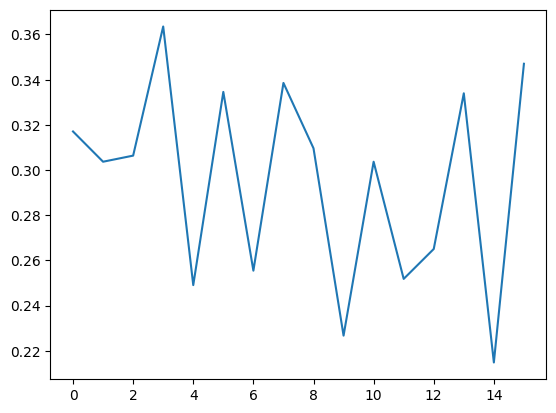

In [195]:
plt.plot(range(len(mat_hw)), [max(row) for row in mat_hw])

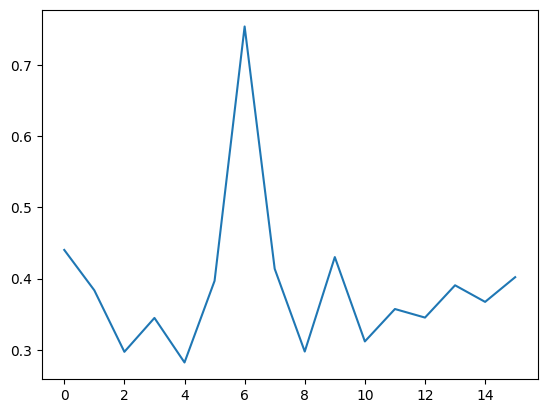

In [196]:
plt.plot(range(len(mat_hd)), [max(row) for row in mat_hd])

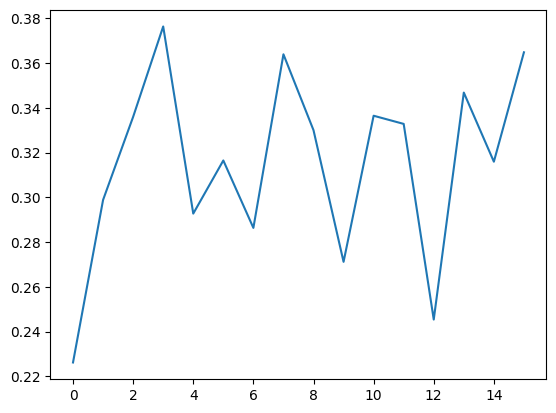

In [197]:
plt.plot(range(len(mat_val)), [max(row) for row in mat_val])